In [1]:
import pandas as pd
import numpy as np

In [2]:
import random
random.seed(12486192)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
df = pd.read_csv('musicData.csv')
print(df.head())

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability  duration_ms  energy  instrumentalness key  \
0       0.00468         0.652         -1.0   0.941           0.79200  A#   
1       0.01270         0.622     218293.0   0.890           0.95000   D   
2       0.00306         0.620     215613.0   0.755           0.01180  G#   
3       0.02540         0.774     166875.0   0.700           0.00253  C#   
4       0.00465         0.638     222369.0   0.587           0.90900  F#   

   liveness  loudness   mode  speechiness               tempo obtained_date  \
0     0.115    -5.2

In [53]:
print(len(df))

50005


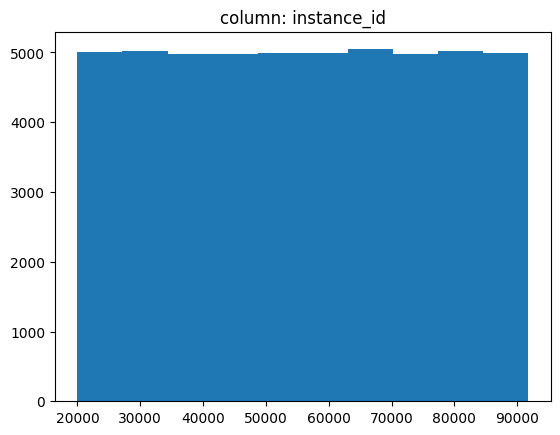

the following column did not print: artist_name
the following column did not print: track_name


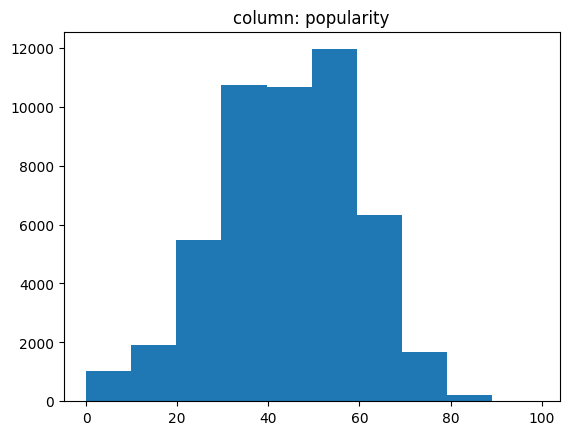

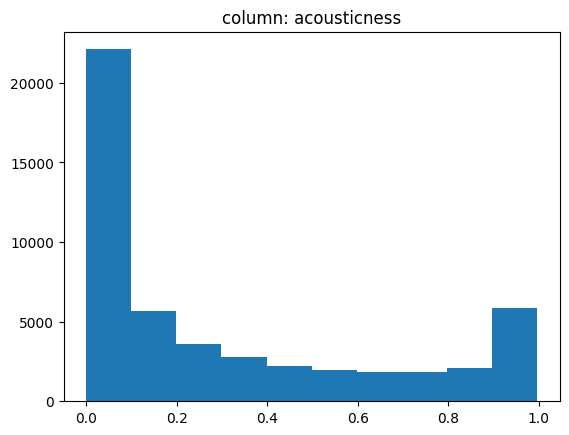

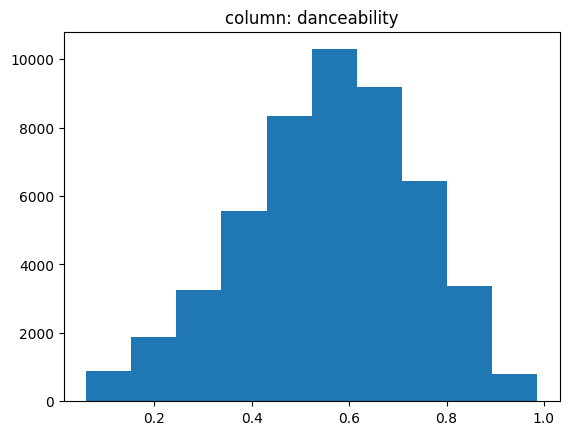

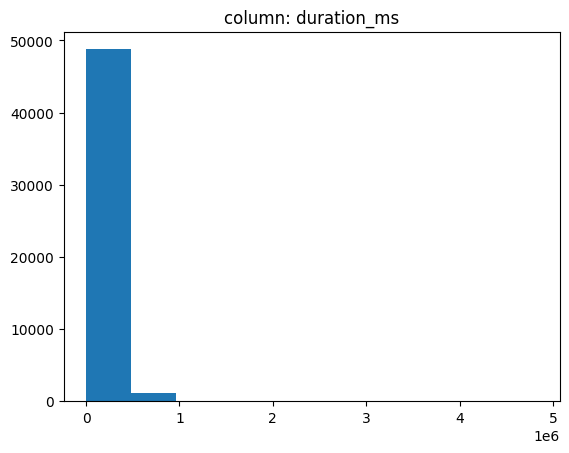

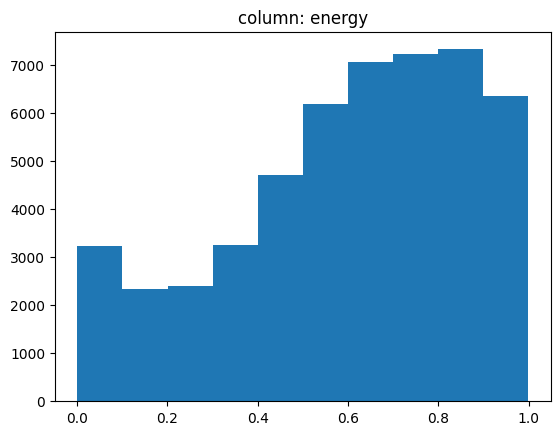

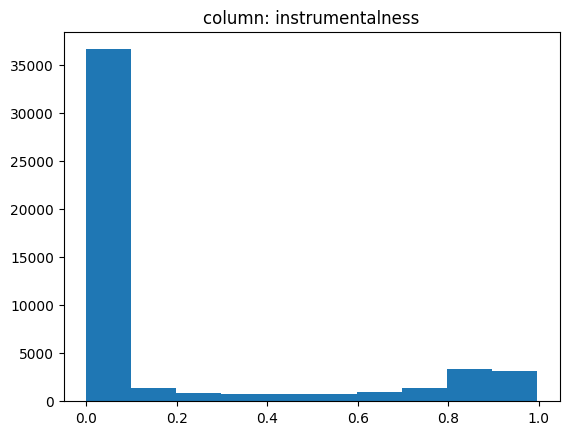

the following column did not print: key


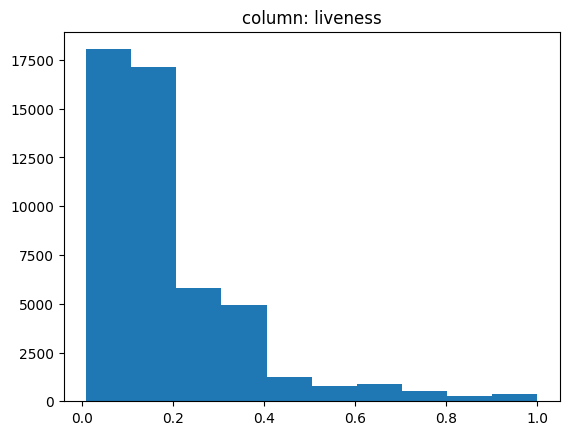

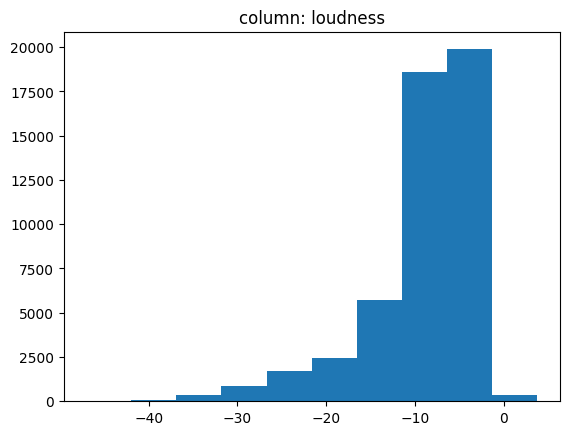

the following column did not print: mode


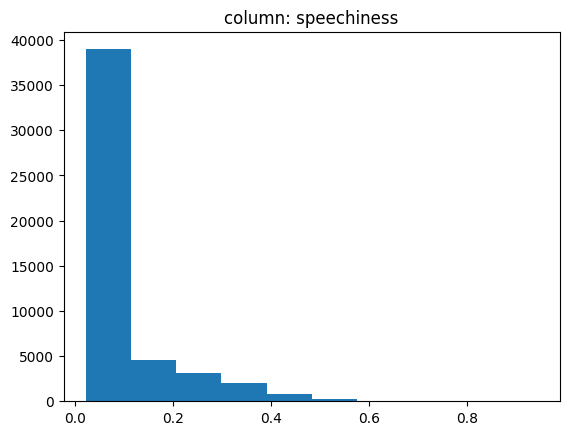

the following column did not print: tempo
the following column did not print: obtained_date


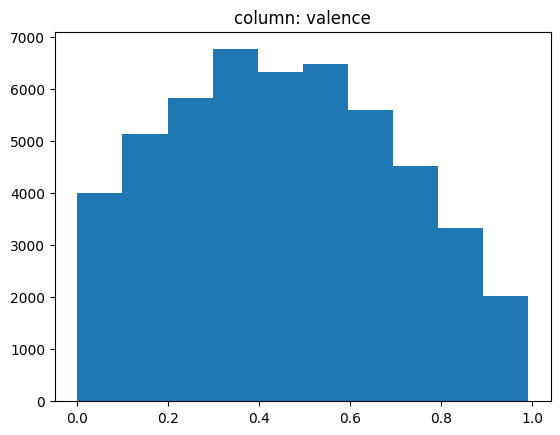

the following column did not print: music_genre


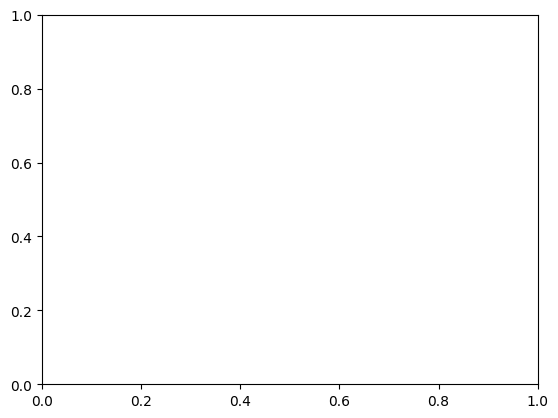

In [4]:
#Plotting datacolumns to get a feeling for them
import matplotlib.pyplot as plt

for column in df.columns:
    try:
        plt.hist(df[column])
        plt.title('column: {}'.format(column))
        plt.show()
    except:
        print("the following column did not print: {}".format(column))


In [5]:
#From the plots and printing we can see some issues with **tempo, duration**

# Convert the columns to numeric types, coercing errors to NaN
df[['tempo', 'duration_ms']] = df[['tempo', 'duration_ms']].apply(pd.to_numeric, errors='coerce')

# Check for negative values in columns X and Y
negative_mask = (df[['tempo', 'duration_ms']] < 0).any(axis=1)

# Remove rows with non-numeric or negative values in columns X or Y
cleaned_df = df[~negative_mask]

In [6]:
#Checking viability for certain columns for prediction
print(len(set(df['artist_name'])))
print(len(set(df['key'])))
print(len(set(df['mode'])))
print(len(set(df['music_genre'])))

6864
13
3
11


In [7]:
#Goal is to classify **music_genre** of the song
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = df.drop(columns=['music_genre','track_name','obtained_date'])
y = df[['music_genre','instance_id']]

#Picking columns for encoding
columns_for_encoding = ['artist_name','key','mode']

# Extract the specified columns from the DataFrame
X_train_cat = df[['artist_name','key','mode','instance_id']]
X_train_noncat = df.drop(columns=columns_for_encoding)
X_train_noncat=X_train_noncat.drop(columns=['track_name','music_genre','obtained_date'])
X_train_noncat_instances = X_train_noncat[['instance_id']]
X_train_cat_instances = X_train_cat[['instance_id']]

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')

# Drop the 'instance_id' column and reassign the modified DataFrame
X_train_cat = X_train_cat.drop(columns=['instance_id'])

# Fit and transform the categorical features in the training data
X_train_encoded = encoder.fit_transform(X_train_cat)


# Get feature names after encoding
feature_names = encoder.get_feature_names_out(['artist_name','key','mode'])

# Convert the encoded features to DataFrame for training data
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=feature_names)
X_train_cats = pd.concat([pd.DataFrame(X_train_cat_instances),pd.DataFrame(X_train_encoded_df)],axis=1)



In [9]:
print(X_train_noncat.columns)

Index(['instance_id', 'popularity', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence'],
      dtype='object')


In [10]:
# Initialize the StandardScaler
scaler = StandardScaler()

#Dropping instance_id and readding after scaling
X_train_noncat.drop(columns=['instance_id'])

# Fit the scaler to the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train_noncat)
X_train_noncats = pd.concat([pd.DataFrame(X_train_noncat_instances),pd.DataFrame(X_train_scaled)],axis=1)

In [11]:
# Change the data type of specific columns to float64 in X_train_cats
X_train_cats[['instance_id']] = X_train_cats[['instance_id']].astype('float64')
X_train_noncats[['instance_id']] = X_train_noncats[['instance_id']].astype('float64')

In [12]:
print(X_train_cats.columns)
print(X_train_noncats.columns)

Index(['instance_id', 'artist_name_!!!', 'artist_name_"Weird Al" Yankovic',
       'artist_name_$NOT', 'artist_name_$tupid Young',
       'artist_name_$uicideBoy$', 'artist_name_(Hed) P.E.',
       'artist_name_(Sandy) Alex G', 'artist_name_03 Greedo',
       'artist_name_04 Limited Sazabys',
       ...
       'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'key_nan',
       'mode_Major', 'mode_Minor', 'mode_nan'],
      dtype='object', length=6881)
Index(['instance_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='object')


In [13]:
# We want to remove rows where the data is empty
filtered_df_train_cats = X_train_cats[X_train_cats.notna().all(axis=1)]
filtered_df_train_noncats = X_train_noncats[X_train_noncats.notna().all(axis=1)]

In [14]:
#Combining Xs
train_df = pd.merge(filtered_df_train_cats, filtered_df_train_noncats, on ='instance_id', how='inner')

In [15]:

train_df.columns = train_df.columns.astype(str)

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

dta_for_pca = train_df.drop(columns=['instance_id'])

# Perform PCA
pca = PCA(n_components = 14)  # Specify the number of components you want
pca_result = pca.fit_transform(dta_for_pca)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8','PC9','PC10','PC11','PC12','PC13','PC14'])

# Optionally, you can access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)

# Optionally, you can access the principal components (eigenvectors)
principal_components = pca.components_
print("Principal components (eigenvectors):", principal_components)


Explained variance ratio: [0.25797149 0.09316494 0.07347732 0.06966438 0.06790709 0.06597803
 0.05781816 0.0516331  0.04185991 0.0321347  0.03105065 0.01794579
 0.00786717 0.00781631]
Principal components (eigenvectors): [[-1.41660236e-04 -3.25555436e-06 -1.37687912e-05 ... -1.74297902e-01
  -1.54513054e-01 -2.75889154e-01]
 [-4.48349330e-05 -2.31110918e-05 -1.22520784e-04 ... -2.97532923e-01
   3.64846012e-01 -1.23525141e-01]
 [-2.71436672e-04  1.61117079e-05  1.46496480e-04 ...  6.32771065e-01
  -8.69538499e-02 -3.46300423e-01]
 ...
 [ 3.61205249e-04  6.10774680e-05 -9.37301105e-05 ... -9.14739888e-03
  -3.16446380e-03  9.96267266e-02]
 [ 1.16535232e-04 -4.22744508e-05 -4.30359808e-07 ... -3.69917510e-02
   1.41895389e-02 -1.01701284e-01]
 [-4.54830486e-04  3.44155553e-05  1.00175843e-04 ...  4.12223202e-02
  -3.48174022e-03  7.90446981e-02]]


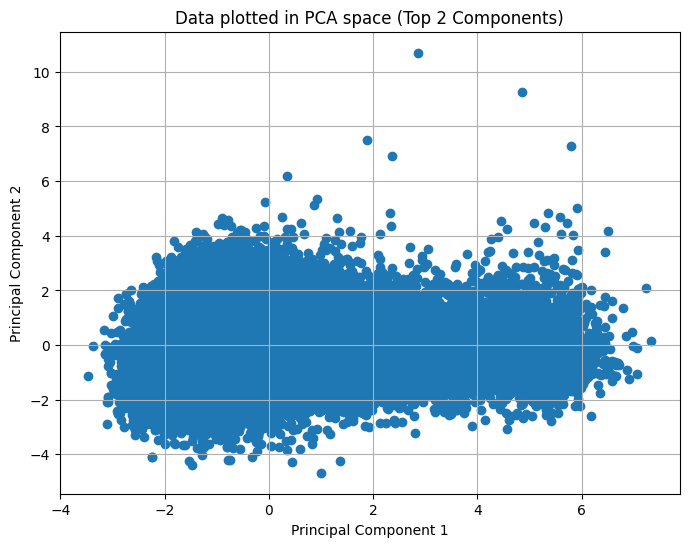

Variance explained by the top ten components: 81.16%


In [17]:
explained_variance_ratio = pca.explained_variance_ratio_
top_two_components = pca_df.iloc[:, :2]

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(top_two_components['PC1'], top_two_components['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data plotted in PCA space (Top 2 Components)')
plt.grid(True)
plt.show()

# Report the amount of variance explained by the top two components
variance_explained = explained_variance_ratio[:10].sum()
print(f"Variance explained by the top ten components: {variance_explained * 100:.2f}%")

In [18]:
pca_df_with_ids = pd.concat([pca_df, train_df[['instance_id']]], axis=1)

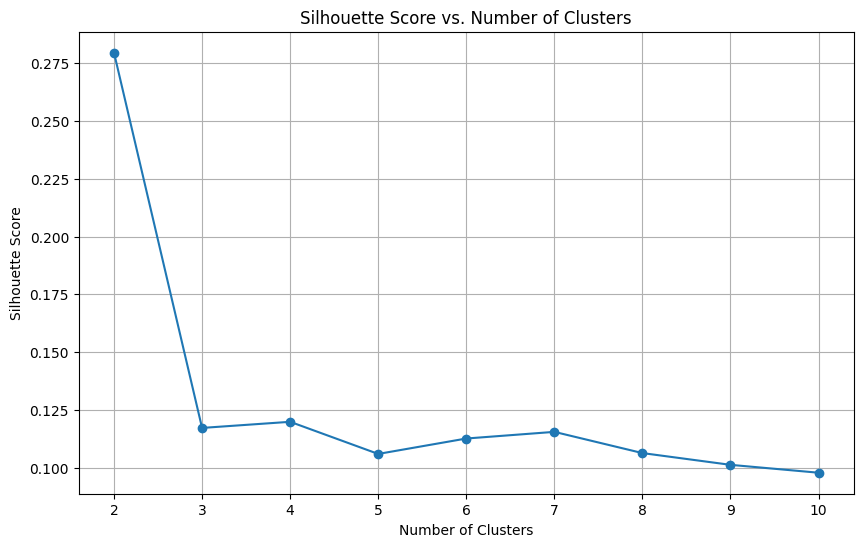

In [19]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np


# Assuming pca_df_with_ids is your DataFrame after PCA
# Drop the "instance_id" column
data_for_clustering = pca_df_with_ids.drop(columns=['instance_id'])

silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_result)
    silhouette_avg = silhouette_score(pca_result, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

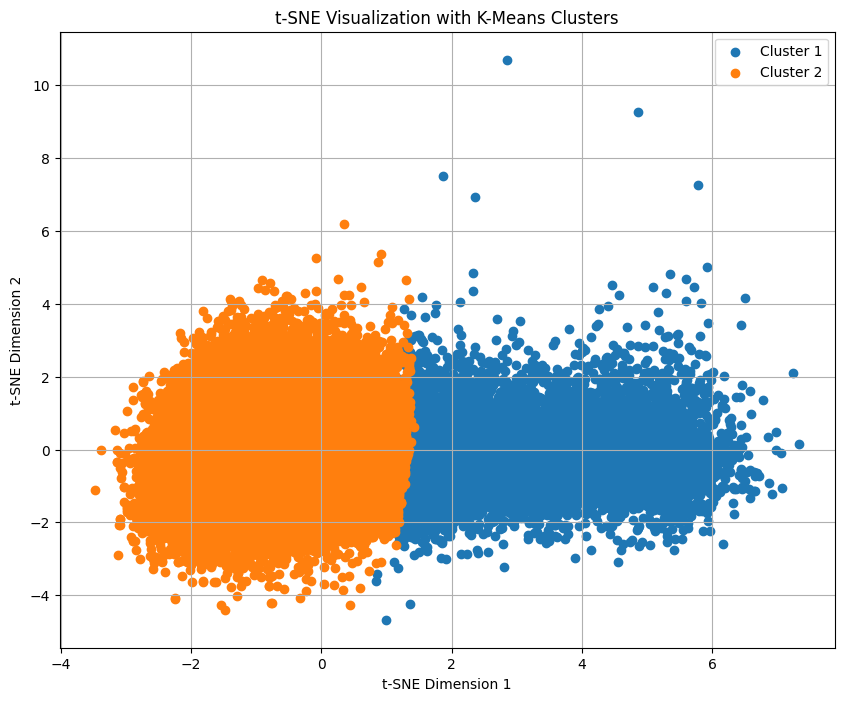

In [20]:
# Step 3: K-Means Clustering with Optimal Number of Clusters
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because the range starts from 2
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_result)

# Step 4: Visualization
plt.figure(figsize=(10, 8))
for cluster_label in range(optimal_num_clusters):
    plt.scatter(pca_result[cluster_labels == cluster_label, 0],
                pca_result[cluster_labels == cluster_label, 1],
                label=f'Cluster {cluster_label+1}')
plt.title('t-SNE Visualization with K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Print the explained variance ratio for each principal component
print("Explained variance ratio by each principal component:")
for i, explained_variance_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {explained_variance_ratio:.2f}")

Explained variance ratio by each principal component:
PC1: 0.26
PC2: 0.09
PC3: 0.07
PC4: 0.07
PC5: 0.07
PC6: 0.07
PC7: 0.06
PC8: 0.05
PC9: 0.04
PC10: 0.03
PC11: 0.03
PC12: 0.02
PC13: 0.01
PC14: 0.01


Ultimately relatively satisified with the variance explained, gonna stick with PCA for reduction

In [22]:
#Readding target
ndf = pd.merge(pca_df_with_ids,y,on='instance_id',how='inner')

In [23]:
#Repeating plotting for sanity check WARNING ITS A LOT OF COLUMNS WOULD NOT RECOMMEND RUNNING
#for column in train_df.columns:
    #try:
        #plt.hist(train_df[column])
        #plt.title('column: {}'.format(column))
        #plt.show()
    #except:
        #print("the following column did not print: {}".format(column))

In [24]:
print("Number of classes: {}".format(len(set(ndf['music_genre']))))
num_classes = len(set(ndf['music_genre']))
X = ndf.drop(columns=['music_genre'])
y = ndf[['music_genre','instance_id']]

Number of classes: 10


In [25]:
print(set(ndf['music_genre']))

{'Rap', 'Anime', 'Alternative', 'Rock', 'Jazz', 'Country', 'Blues', 'Classical', 'Electronic', 'Hip-Hop'}


In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have a DataFrame 'ndf' containing features and labels
# For each genre, split the data into training and testing sets
train_indices = []
val_indices = []
test_indices = []

genre_mapping = {
    'Anime': 0,
    'Rap': 1,
    'Country': 2,
    'Alternative': 3,
    'Rock': 4,
    'Blues': 5,
    'Jazz': 6,
    'Hip-Hop': 7,
    'Electronic': 8,
    'Classical': 9
}

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the 'music_genre' column and transform it to numerical labels
ndf['music_genre'] = label_encoder.fit_transform(ndf['music_genre'])

for genre in ndf['music_genre'].unique():
    # Select indices corresponding to the current genre
    genre_indices = ndf[ndf['music_genre'] == genre].index.to_numpy()

    # Randomly shuffle the indices
    np.random.shuffle(genre_indices)

    # Split indices into training and testing sets
    train_indices.extend(genre_indices[:4000])  # Use 4500 songs for training
    val_indices.extend(genre_indices[4000:4500])  # Use 500 songs for testing
    test_indices.extend(genre_indices[4500:5000])  # Use 500 songs for testing

# Use the selected indices to create training and testing sets
train_set = ndf.loc[train_indices]
val_set = ndf.loc[val_indices]
test_set = ndf.loc[test_indices]

# Split features and labels for training, validation, and testing sets
X_train, y_train = train_set.drop(columns=['music_genre']), train_set['music_genre']
X_val, y_val = val_set.drop(columns=['music_genre']), val_set['music_genre']
X_test, y_test = test_set.drop(columns=['music_genre']), test_set['music_genre']

# Now you have X_train, X_test, y_train, and y_test according to the specified train/test split

In [27]:
print(X_train.columns) #Another sanity check
input_dim = len(X_train.columns) - 1

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'instance_id'],
      dtype='object')


In [28]:
X_train = X_train.drop(columns=['instance_id'])
y_train = y_train.drop(columns=['instance_id'])
X_val = X_val.drop(columns=['instance_id'])
y_val = y_val.drop(columns=['instance_id'])
X_test = X_test.drop(columns=['instance_id'])
y_test = y_test.drop(columns=['instance_id'])


In [29]:
import pandas as pd

# Assuming X_train, X_val, X_test, y_train, y_val, y_test are your input and target data

# Data Inspection
print("Shape of input data (X_train):", X_train.shape)
print("Shape of input data (X_val):", X_val.shape)
print("Shape of input data (X_test):", X_test.shape)
print("Shape of target data (y_train):", y_train.shape)
print("Shape of target data (y_val):", y_val.shape)
print("Shape of target data (y_test):", y_test.shape)

# Print the first few rows of the input data (X_train)
print("\nFirst few rows of input data (X_train):")
print(X_train.head())

# Print the first few rows of the target data (y_train)
print("\nFirst few rows of target data (y_train):")
print(y_train.head())

# NaN Values Check
print("\nNaN Values Check:")
print("For input data (X_train):")
print(X_train.isnull().sum())
print("\nFor input data (X_val):")
print(X_val.isnull().sum())
print("\nFor input data (X_test):")
print(X_test.isnull().sum())
print("\nFor target data (y_train):")
print(y_train.isnull().sum())
print("\nFor target data (y_val):")
print(y_val.isnull().sum())
print("\nFor target data (y_test):")
print(y_test.isnull().sum())


Shape of input data (X_train): (40000, 14)
Shape of input data (X_val): (4914, 14)
Shape of input data (X_test): (106, 14)
Shape of target data (y_train): (40000,)
Shape of target data (y_val): (4914,)
Shape of target data (y_test): (106,)

First few rows of input data (X_train):
           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
4009 -2.063347  0.834397  1.943202  0.599583 -0.630858 -2.211692  1.932617   
1529 -0.473985  1.577855 -0.101631  0.140629  1.100348 -0.957025 -0.686450   
1446 -0.957318 -0.600960 -1.907469 -1.061384 -0.603518  1.182594  1.349722   
4031 -1.213537  1.066929 -0.245523 -1.565018 -0.032678  0.159384  0.452571   
712  -0.206237 -0.017434 -0.603073 -1.714348  0.244516  0.097621  0.389946   

           PC8       PC9      PC10      PC11      PC12      PC13      PC14  
4009 -1.301559  2.023651  1.431674 -0.390398  0.045467  0.064019 -0.252715  
1529 -0.955868 -0.119205 -0.377258  0.684742 -0.139201  0.551841  0.689093  
1446 -1.564422 -1.2

In [30]:
# Print the lengths of the input and target data
print("Length of training input data (X_train):", len(X_train))
print("Length of testing input data (X_test):", len(X_test))
print("Length of training target data (y_train):", len(y_train))
print("Length of testing target data (y_test):", len(y_test))

Length of training input data (X_train): 40000
Length of testing input data (X_test): 106
Length of training target data (y_train): 40000
Length of testing target data (y_test): 106


In [31]:
print("Length of training target data (X_val):", len(X_val))
print("Length of testing target data (y_val):", len(y_val))

Length of training target data (X_val): 4914
Length of testing target data (y_val): 4914


In [32]:
non_clustered_df = pd.merge(train_df,y,on='instance_id',how='inner')

In [49]:
#Trying out the NN for classification first
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD

# Define the SGD optimizer with desired parameters
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dense(32,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(optimizer=sgd_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_val,y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/150


c:\Users\sageh\Downloads\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - accuracy: 0.2676 - loss: 2.0153 - val_accuracy: 0.4733 - val_loss: 1.4009
Epoch 2/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.4948 - loss: 1.3605 - val_accuracy: 0.5252 - val_loss: 1.2512
Epoch 3/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.5177 - loss: 1.2652 - val_accuracy: 0.5411 - val_loss: 1.2071
Epoch 4/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.5378 - loss: 1.2205 - val_accuracy: 0.5511 - val_loss: 1.1856
Epoch 5/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.5374 - loss: 1.2110 - val_accuracy: 0.5578 - val_loss: 1.1698
Epoch 6/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.5444 - loss: 1.1886 - val_accuracy: 0.5580 - val_loss: 1.1620
Epoch 7/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - accuracy: 0.5483 - loss: 1.1858 - val_accuracy: 0.5613 - val_loss: 1.1522
Epoch 8/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.5567 - los

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


c:\Users\sageh\Downloads\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\sageh\Downloads\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\sageh\Downloads\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\sageh\Downloads\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\sageh\Downloads\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\sageh\

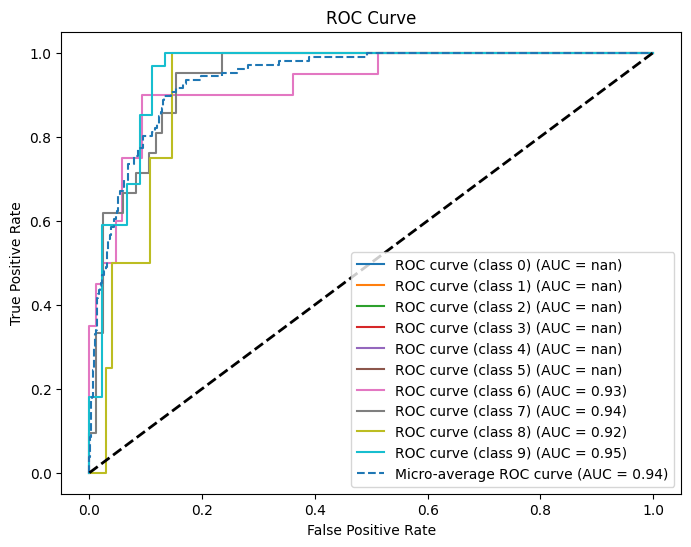

AUC for class 0: nan
AUC for class 1: nan
AUC for class 2: nan
AUC for class 3: nan
AUC for class 4: nan
AUC for class 5: nan
AUC for class 6: 0.93
AUC for class 7: 0.94
AUC for class 8: 0.92
AUC for class 9: 0.95
Micro-average AUC: 0.94


In [50]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[y_test].ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC scores for each class
for i in range(num_classes):
    print(f'AUC for class {i}: {roc_auc[i]:.2f}')
print(f'Micro-average AUC: {roc_auc_micro:.2f}')


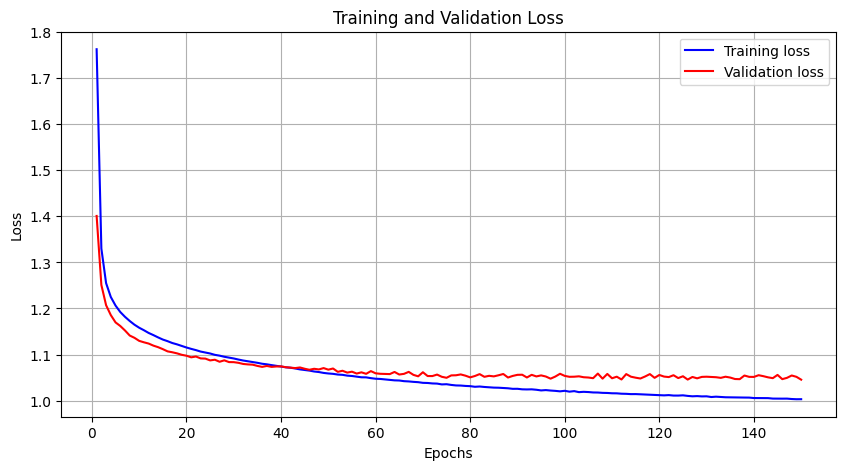

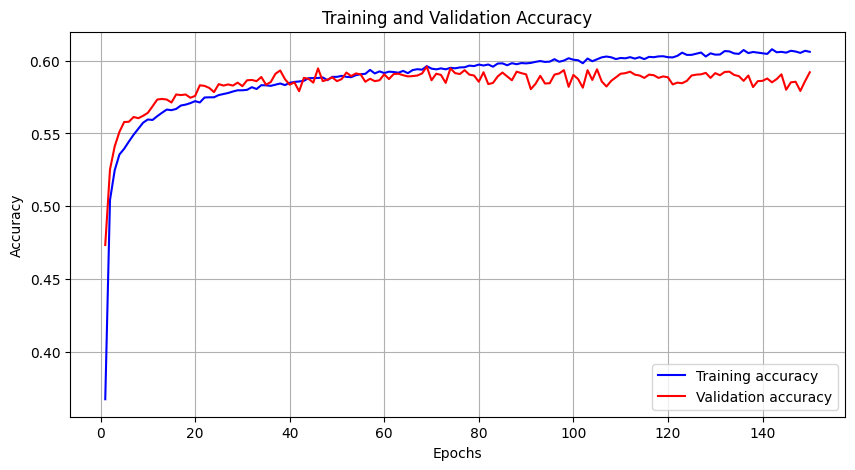

In [51]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


NN seems ok but gonna try decision tree now

In [51]:
#Trying a Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Define the parameters for the XGBoost model
params = {
    'tree_method': 'gpu_hist',  # Use GPU for training
    'predictor': 'gpu_predictor',  # Use GPU for prediction
    'max_depth': 1,
    'learning_rate': 1e-2,
    'n_estimators': 2000
}

# Create and fit the XGBoost model
bdt = xgb.XGBClassifier(**params)
bdt.fit(X_train, y_train)

# Calculate accuracy on the validation set
preds = bdt.predict(X_test)
print(np.sum(preds == y_test)/len(preds))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:39:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:39:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


0.5188679245283019


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:39:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Ehh gonna go with Neural Network for final model